# Studying the intertidal area

#### For colab users:

In [1]:
#if you are using colab, you can use:
#!pip install git+https://github.com/lonanni/WaterNets;
#from WaterNets_project import sediment_utils

#### if working locally - after cloning/downloading this repository:


In [2]:
import sys
import os
WaterNets_project_path = "/home/lolla/RemoteSensing_Environment_Projects/WaterNets_project"
#change it with the appropriate path
sys.path.append(os.path.abspath(WaterNets_project_path))

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import glob
import os
from matplotlib import colors
import sediment_utils

import rasterio
#This stops the excessive warnings
from rasterio import logging
log = logging.getLogger()
log.setLevel(logging.ERROR)


import warnings
warnings.filterwarnings("ignore")



2025-01-17 12:33:01.884993: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-17 12:33:01.889012: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-17 12:33:01.901356: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-17 12:33:01.923817: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-17 12:33:01.929794: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-17 12:33:01.944972: I tensorflow/core/platform/cpu_feature_gu

We use here the NN trained and the scaler constructed in https://github.com/lonanni/RemoteSensing_Environment_Projects/blob/main/NN_BCLWMasks.ipynb.

You can also download them from here:

NN --> https://drive.google.com/file/d/1dGnr894VTCiJL4qa7jdsuXqfH53IZcFK/view?usp=sharing

Scaler --> https://drive.google.com/file/d/1-1prOW7ac75DRVQ4U-r3jR883WA6UzfX/view?usp=sharing


In [4]:
NN_files_dir = "../NN_Scaler/" # change with the location where you have these files
BCLWMasks = tf.keras.models.load_model(NN_files_dir+"BCLWMasks.h5")
SimpleScaler = sediment_utils.SimpleScaler

In [5]:
import joblib
scaler_filename = NN_files_dir+"scaler_BCLW.gz"
scaler_BCLW = joblib.load(scaler_filename)

In [6]:
def intertidal_area(path_main_directory):
    if not os.path.isdir(path_main_directory):
        return "Main directory does not exist."

    contents = os.listdir(path_main_directory)

    subdirectory = path_main_directory
    list_date = os.listdir(subdirectory)

    prediction_count = 0  # To count number of predictions plotted
    good_images= 0

    water_inter = np.zeros(shape=(1000000))
    for dirpath, dirnames, filenames in os.walk(subdirectory):
        if filenames:
            for filename in filenames[::-1]:

                file_path = os.path.join(dirpath, filename)
                # Plotting and image processing starts here
                if os.path.isfile(file_path) == True:

                  RAW_reader = rasterio.open(file_path)
                  image_shape = RAW_reader.read(1).shape
                  raw_image = np.dstack([
                      RAW_reader.read(1),
                      RAW_reader.read(2),
                      RAW_reader.read(3),
                      RAW_reader.read(4),
                      RAW_reader.read(5),
                      RAW_reader.read(6),
                  ])


                  # Resize the images
                  test_image_water = scaler_BCLW.transform(raw_image.reshape((image_shape[0], image_shape[1], 6)))

                  predictions = BCLWMasks(test_image_water.reshape((np.product(image_shape), 6)))
                  predicted_classes = np.argmax(predictions, axis=1)

                  prediction_count += 1
                if len(predicted_classes[predicted_classes==2])< len(predictions)*.05:
                    if len(predicted_classes[predicted_classes==3])< len(predictions)*.05:

                      water_inter += predictions[:,1]
                      good_images += 1




                # when we have 20 good images, we use these images to define the intertidal area
                if prediction_count== 20:
                  water_mean = water_inter / good_images
                  intertidal_zone_mask = np.logical_and(water_mean > np.std(water_mean), water_mean < 2*np.std(water_mean))
                  im = plt.imshow(intertidal_zone_mask.reshape((image_shape[0], image_shape[1])))
                  plt.colorbar(im)
                  plt.show()

                  return intertidal_zone_mask.reshape((image_shape[0], image_shape[1]))

                if prediction_count >= 20:
                  break

#### You can download the LandSat8 dataset used from here: https://drive.google.com/drive/folders/1R-LEvnbh3n78v8IpDtFH9aS8M8l2A2g0?usp=sharing

Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
2025-01-17 12:33:05.404547: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 512000000 exceeds 10% of free system memory.
2025-01-17 12:33:05.609773: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 512000000 exceeds 10% of free system memory.
2025-01-17 12:33:05.817316: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 512000000 exceeds 10% of free system memory.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
2025-01-17 12:33:07.753809: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 512000000 exceeds 10% of free system memory.
2025-01-17 12:33:07.948922: W external/local_tsl/tsl/framework/cpu_all

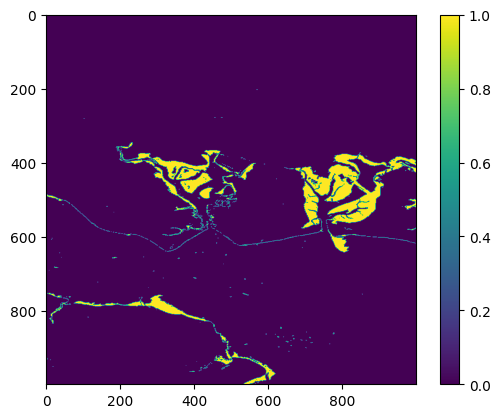

In [7]:
intertidal_mask = intertidal_area('./L8/Portsmouth');

In [8]:
np.save('./intertidal_mask', intertidal_mask)